# **Food-101 - Fellowship.ai Challenge**

    Food-101 is a challenging vision problem, but everyone can relate to it.  Recent SoTA is ~80% top-1, 90% top-5.  These approaches rely on lots of TTA, large networks and  even novel architectures.

    Train a decent model >85% accuracy for top-1 for the test set, using a ResNet50 or smaller network with a reasonable set of augmentations.

**Source:**

    This is the Food 101 dataset, also available from https://www.vision.ee.ethz.ch/datasets_extra/food-101/

**Project Description:** 

    It contains images of food, organized by type of food. It was used in the Paper "Food-101 – Mining Discriminative Components with Random Forests" by Lukas Bossard, Matthieu Guillaumin and Luc Van Gool. It's a good (large dataset) for testing computer vision techniques.

# **Importing Libraries**

In [1]:
from __future__ import print_function, division

# Torch Library

import torch
import torch.nn as nn
from torch import optim, cuda
from torch.optim import lr_scheduler
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
from torchsummary import summary

# System Libraries

import time
import os
import copy
import random
from timeit import default_timer as timer

# Misc Libraries

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import tensorflow as tf
from collections import defaultdict
import shutil
from shutil import copy
from shutil import copytree, rmtree
from PIL import Image

import warnings
warnings.filterwarnings('ignore')

# **Device Configuration**

In [2]:
train_on_gpu = cuda.is_available()
print(f'Train on GPU: {train_on_gpu}')

# Number of gpus
if train_on_gpu:
    gpu_count = cuda.device_count()
    print(f'{gpu_count} GPU detected: {tf.test.gpu_device_name()}')
    if gpu_count > 1:
        multi_gpu = True

        else:
        multi_gpu = False


Train on GPU: True
1 GPU detected: /device:GPU:0


In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print('Device Used:', device)

#Additional Info when using cuda
if device.type == 'cuda':
    print('Graphics Card:',torch.cuda.get_device_name(0))
    print('Memory Usage:   Allocated - ', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('\t\tCached    - ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Device Used: cuda
Graphics Card: GeForce GTX 1050 Ti
Memory Usage:   Allocated -  0.0 GB
		Cached    -  0.0 GB


In [4]:
ls /home/prakash/Desktop/fellowship.ai/food-101

images/                models/     test_samples/   validation/
license_agreement.txt  README.txt  train/          validation_samples/
meta/                  test/       train_samples/


# **Data Preprocessing**

In [5]:
# List of Directories

root_dir = '/home/prakash/Desktop/fellowship.ai/food-101/images/'
food_dir = '/home/prakash/Desktop/fellowship.ai/food-101/'
train_dir = '/home/prakash/Desktop/fellowship.ai/food-101/train/'
test_dir = '/home/prakash/Desktop/fellowship.ai/food-101/test/'
val_dir = '/home/prakash/Desktop/fellowship.ai/food-101/validation/'
train_samples_dir = '/home/prakash/Desktop/fellowship.ai/food-101/train_samples/'
test_samples_dir = '/home/prakash/Desktop/fellowship.ai/food-101/test_samples/'
val_samples_dir = '/home/prakash/Desktop/fellowship.ai/food-101/validation_samples/' 
models_dir = '/home/prakash/Desktop/fellowship.ai/food-101/models/'
train_txt_file = '/home/prakash/Desktop/fellowship.ai/food-101/meta/train.txt'
test_txt_file = '/home/prakash/Desktop/fellowship.ai/food-101/meta/test.txt'

classes = sorted(os.listdir(root_dir))

print(f'Number of Classes present in the data set: {len(classes)} \n')
print(f'Classes Description:\n')
print(*classes, sep = ',')

Number of Classes present in the data set: 101 

Classes Description:

apple_pie,baby_back_ribs,baklava,beef_carpaccio,beef_tartare,beet_salad,beignets,bibimbap,bread_pudding,breakfast_burrito,bruschetta,caesar_salad,cannoli,caprese_salad,carrot_cake,ceviche,cheese_plate,cheesecake,chicken_curry,chicken_quesadilla,chicken_wings,chocolate_cake,chocolate_mousse,churros,clam_chowder,club_sandwich,crab_cakes,creme_brulee,croque_madame,cup_cakes,deviled_eggs,donuts,dumplings,edamame,eggs_benedict,escargots,falafel,filet_mignon,fish_and_chips,foie_gras,french_fries,french_onion_soup,french_toast,fried_calamari,fried_rice,frozen_yogurt,garlic_bread,gnocchi,greek_salad,grilled_cheese_sandwich,grilled_salmon,guacamole,gyoza,hamburger,hot_and_sour_soup,hot_dog,huevos_rancheros,hummus,ice_cream,lasagna,lobster_bisque,lobster_roll_sandwich,macaroni_and_cheese,macarons,miso_soup,mussels,nachos,omelette,onion_rings,oysters,pad_thai,paella,pancakes,panna_cotta,peking_duck,pho,pizza,pork_chop,poutine,

In [ ]:
# Function to create train and test image directory 

def prepare_data(filepath, src,dest):
  classes_images = defaultdict(list)
  with open(filepath, 'r') as txt:
      paths = [read.strip() for read in txt.readlines()]
      for p in paths:
        food = p.split('/')
        classes_images[food[0]].append(food[1] + '.jpg')

  for food in classes_images.keys():
    if not os.path.exists(os.path.join(dest,food)):
      os.makedirs(os.path.join(dest,food))
    for i in classes_images[food]:
      copy(os.path.join(src,food,i), os.path.join(dest,food,i))

# Creating Train images directory
prepare_data(train_txt_file, root_dir, train_dir)

# Creating Test images directory
prepare_data(test_txt_file, root_dir, test_dir)

# Creating Validation images directory

os.makedirs(val_dir)
for i in classes:
    os.mkdir(os.path.join(val_dir,i))
    sourceN = train_dir + i
    destN = val_dir + i
    
    files = os.listdir(sourceN)
    
    for f in files:
       if np.random.rand(1) < 0.2:
           shutil.move(sourceN + '/'+ f, destN + '/'+ f)

In [6]:
# Function to create sample train,test and validation directories 

def sample_data(food_list, srt, dest):
  if os.path.exists(dest):
    rmtree(dest) # removing dataset_mini(if it already exists) folders so that we will have only the classes that we want
  os.makedirs(dest)
  for food_item in food_list :
    copytree(os.path.join(srt,food_item), os.path.join(dest,food_item))

# Creating samples set of food images for testing various models 

food_list = []
for i in range(0,5):
    x = np.random.randint(101)
    food_list.append(classes[x])

sample_data(food_list, train_dir, train_samples_dir)
sample_data(food_list, val_dir, val_samples_dir)
sample_data(food_list, test_dir, test_samples_dir)


In [7]:
print("\nFoods we have selected for testing models:",*food_list, sep =',')

check_train = !find /home/prakash/Desktop/fellowship.ai/food-101/train -type d -or -type f -printf '.' | wc -c
check_test = !find /home/prakash/Desktop/fellowship.ai/food-101/test -type d -or -type f -printf '.' | wc -c
check_val = !find /home/prakash/Desktop/fellowship.ai/food-101/validation -type d -or -type f -printf '.' | wc -c

print("\nNumber of images in Train directory:", *check_train)
print("Number of images in Test directory:", *check_test)
print("Number of images in Validation directory:",*check_val)

check_train_samples = !find /home/prakash/Desktop/fellowship.ai/food-101/train_samples -type d -or -type f -printf '.' | wc -c
check_val_samples = !find /home/prakash/Desktop/fellowship.ai/food-101/validation_samples -type d -or -type f -printf '.' | wc -c
check_test_samples = !find /home/prakash/Desktop/fellowship.ai/food-101/test_samples -type d -or -type f -printf '.' | wc -c

print("\nNumber of images in Sample Train directory:", *check_train_samples)
print("Number of images in Sample Test directory:", *check_test_samples)
print("Number of images in Sample Validation directory:",*check_val_samples)


Foods we have selected for testing models:,frozen_yogurt,lasagna,ravioli,baby_back_ribs,edamame

Number of images in Train directory: 60555
Number of images in Test directory: 25250
Number of images in Validation directory: 15195

Number of images in Sample Train directory: 3045
Number of images in Sample Test directory: 1250
Number of images in Sample Validation directory: 705


# **Data Augmentation**

In [11]:
# Data augmentation and normalization for training

data_transforms = {# Train uses data augmentation
    'train_samples': transforms.Compose([
        transforms.RandomResizedCrop(size = 224, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # Validation does not use augmentation, only normalization is being performed.
    'validation_samples': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(size = 224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    #Test does not use augmentation, only normalization is being performed.
    'test_samples': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(size = 224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'train': transforms.Compose([
        transforms.RandomResizedCrop(size = 224, scale=(0.8, 1.0)),
        transforms.RandomRotation(degrees=15),
        transforms.ColorJitter(),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    # Validation does not use augmentation, only normalization is being performed.
    'validation': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(size = 224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    #Test does not use augmentation, only normalization is being performed.
    'test': transforms.Compose([
        transforms.Resize(224),
        transforms.CenterCrop(size = 224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


# Datasets from each folder
data = {x: datasets.ImageFolder(os.path.join(food_dir, x),data_transforms[x]) 
                  for x in ['train_samples', 'validation_samples','test_samples', 'train', 'validation','test']}

# Dataloader iterators
dataloaders = {x: torch.utils.data.DataLoader(data[x], batch_size=4,shuffle=True, num_workers=1)
              for x in ['train_samples', 'validation_samples', 'test_samples', 'train', 'validation','test']}

dataset_sizes = {x: len(data[x]) for x in ['train_samples','validation_samples','test_samples', 'train', 'validation','test']}
inputs, class_names = next(iter(dataloaders['train']))


# **Data Visualization**

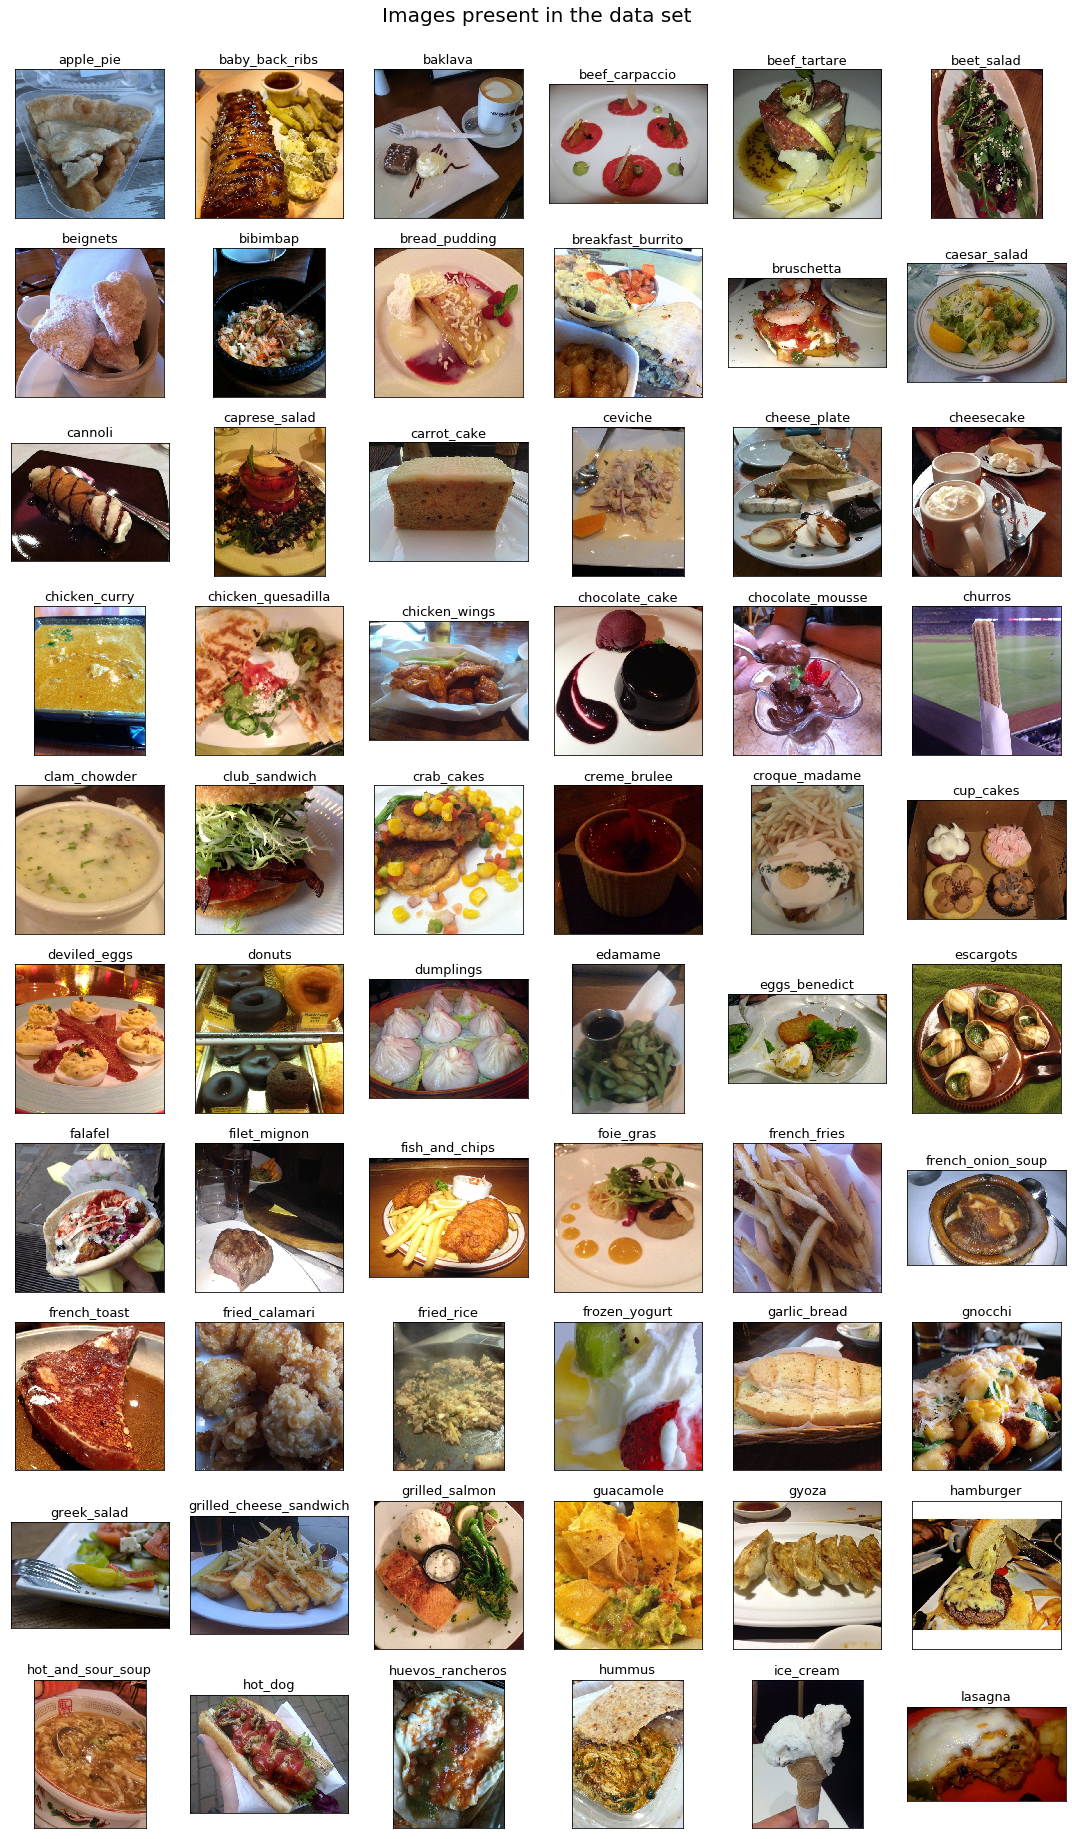

In [13]:
rows, cols = 10, 6
fig, ax = plt.subplots(rows, cols, frameon=False, figsize=(15, 25), tight_layout=True)
fig.suptitle('Images present in the data set', fontsize=20,y=1.02)
for i in range(rows):
    for j in range(cols):
        try:
            food_dir = classes[i*cols + j]
        except:
            break
        img = random.choice(os.listdir(root_dir + food_dir + '/'))
        img = root_dir + food_dir+'/'+img
        img = plt.imread(img)
        ax[i][j].imshow(img)
        ax[i][j].set_title(classes[i*cols + j], fontsize = 13)
        plt.setp(ax, xticks=[], yticks=[])

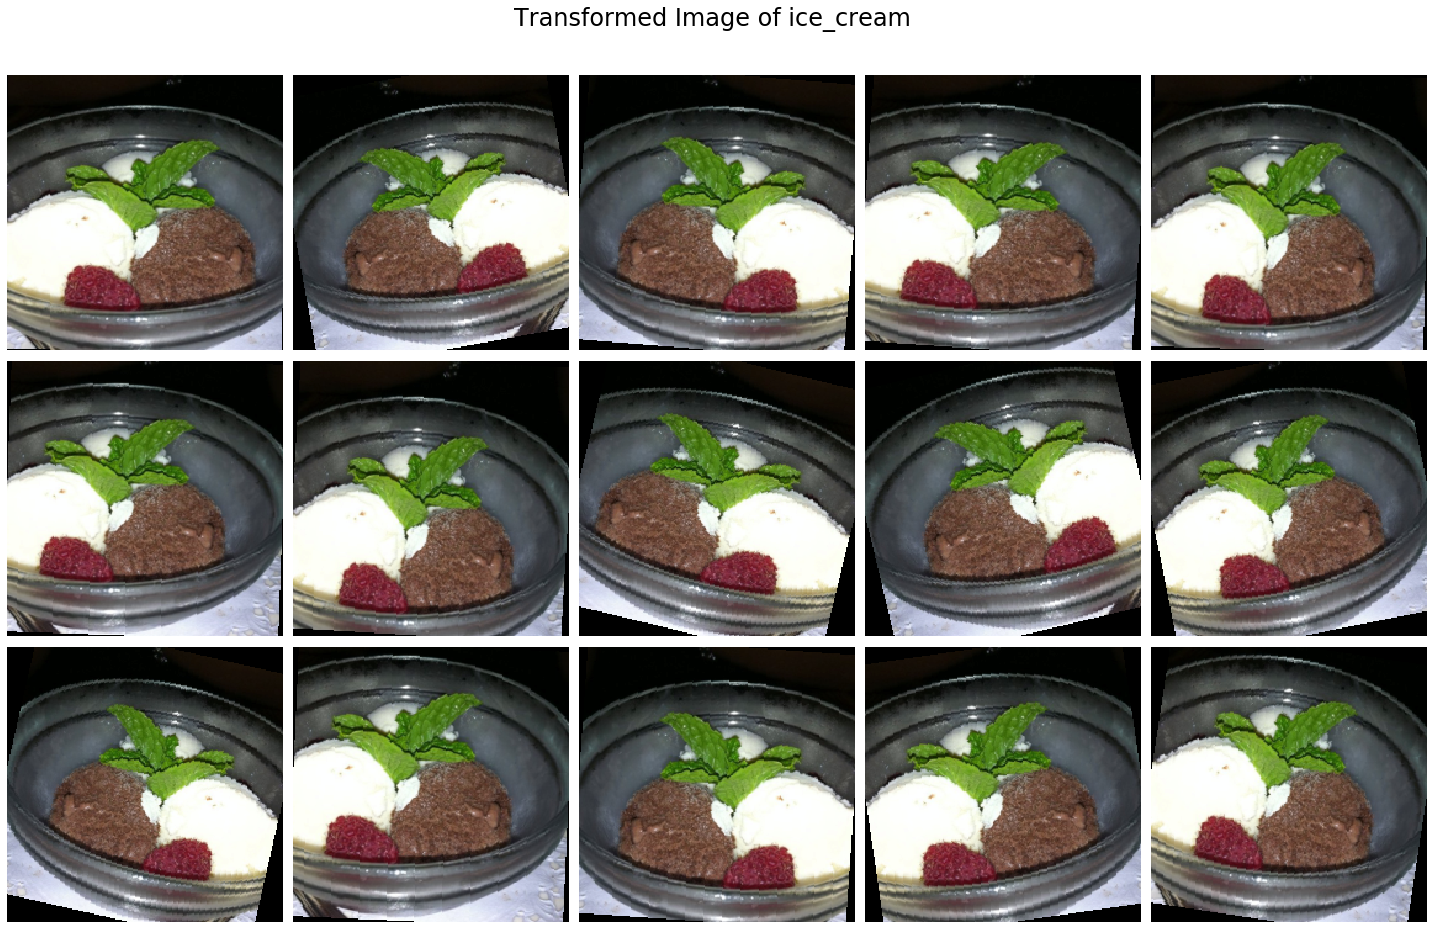

In [14]:
def imshow_tensor(image, ax=None, title=None):
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0)) # Set the color channel as the third dimension
    mean = np.array([0.485, 0.456, 0.406]) # Reverse the preprocessing steps
    std = np.array([0.229, 0.224, 0.225])
    image = std * image + mean 
    image = np.clip(image, 0, 1) # Clip the image pixel values
    ax.imshow(image)
    plt.axis('off')
    return ax, image

img_food_dir = random.choice(os.listdir(train_dir + '/'))
img = random.choice(os.listdir(train_dir+ img_food_dir + '/'))

t = data_transforms['train_samples']
fi_img = train_dir + img_food_dir + '/' + img
ex_img = Image.open(fi_img)
plt.figure(figsize=(20, 20))
plt.suptitle(f'Transformed Image of {img_food_dir} ', fontsize=24,y=1.04)
for i in range(15):
    ax = plt.subplot(5, 5, i + 1)
    _ = imshow_tensor(t(ex_img), ax=ax)

plt.tight_layout()

# **Training the  sample model**

In [15]:
def train(model,criterion,optimizer,train_loader,valid_loader,save_file_name,max_epochs_stop=3,n_epochs=20):

    # Early stopping intialization
    epochs_no_improve = 0
    valid_loss_min = np.Inf
    valid_max_acc = 0
    history = []

    # Number of epochs already trained (if using loaded in model weights)
    try:
        print(f'Model has been trained for: {model.epochs} epochs.\n')
    except:
        model.epochs = 0
        print(f'Starting Training from Scratch.\n')
    overall_start = timer()

    # Main loop
    for epoch in range(n_epochs):
        train_loss = 0.0  # keep track of training and validation loss each epoch
        valid_loss = 0.0
        train_acc = 0
        valid_acc = 0

        # Set to training
        model.train()
        start = timer()

        # Training loop
        for ii, (data, target) in enumerate(train_loader):
             # Tensors to gpu
            if train_on_gpu:
                data, target = data.to(device), target.to(device)

            # Clear gradients
            optimizer.zero_grad()
            # Predicted outputs are log probabilities
            output = model(data)

            # Loss and backpropagation of gradients
            loss = criterion(output, target)
            loss.backward()

            # Update the parameters
            optimizer.step()

            # Track train loss by multiplying average loss by number of examples in batch
            train_loss += loss.item() * data.size(0)

            # Calculate accuracy by finding max log probability
            _, pred = torch.max(output, dim=1)
            correct_tensor = pred.eq(target.data.view_as(pred))
            # Need to convert correct tensor from int to float to average
            accuracy = torch.mean(correct_tensor.type(torch.FloatTensor))
            # Multiply average accuracy times the number of examples in batch
            train_acc += accuracy.item() * data.size(0)

            # Track training progress
            print(
                f'Epoch: {epoch}\t{100 * (ii + 1) / len(train_loader):.2f}% complete -->  {timer() - start:.2f} seconds elapsed in epoch.',
                end='\r')

        # After training loops ends, start validation
        else:
            model.epochs += 1

            # Don't need to keep track of gradients
            with torch.no_grad():
                # Set to evaluation mode
                model.eval()

                # Validation loop
                for data, target in valid_loader:
                    # Tensors to gpu
                    if train_on_gpu:
                        data, target = data.to(device), target.to(device)

                    # Forward pass
                    output = model(data)

                    # Validation loss
                    loss = criterion(output, target)
                    # Multiply average loss times the number of examples in batch
                    valid_loss += loss.item() * data.size(0)

                    # Calculate validation accuracy
                    _, pred = torch.max(output, dim=1)
                    correct_tensor = pred.eq(target.data.view_as(pred))
                    accuracy = torch.mean(
                        correct_tensor.type(torch.FloatTensor))
                    # Multiply average accuracy times the number of examples
                    valid_acc += accuracy.item() * data.size(0)

                # Calculate average losses
                train_loss = train_loss / len(train_loader.dataset)
                valid_loss = valid_loss / len(valid_loader.dataset)

                # Calculate average accuracy
                train_acc = train_acc / len(train_loader.dataset)
                valid_acc = valid_acc / len(valid_loader.dataset)

                history.append([train_loss, valid_loss, train_acc, valid_acc])

                # Print training and validation results
            
                print(
                        f'\n\n\t\tTraining Loss: {train_loss:.4f} \t\tValidation Loss: {valid_loss:.4f}'
                    )
                print(
                        f'\t\tTraining Accuracy: {100 * train_acc:.2f}%\tValidation Accuracy: {100 * valid_acc:.2f}%\n'
                    )

                # Save the model if validation loss decreases
                if valid_loss < valid_loss_min:
                    # Save model
                    torch.save(model.state_dict(), save_file_name)
                    # Track improvement
                    epochs_no_improve = 0
                    valid_loss_min = valid_loss
                    valid_best_acc = valid_acc
                    best_epoch = epoch

                # Otherwise increment count of epochs with no improvement
                else:
                    epochs_no_improve += 1
                    # Trigger early stopping
                    if epochs_no_improve >= max_epochs_stop:
                        print(
                            f'\nEarly Stopping! Total epochs: {epoch}. Best epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_best_acc:.2f}%'
                        )
                        total_time = timer() - overall_start
                        print(
                            f'{total_time:.2f} total seconds elapsed. {total_time / (epoch+1):.2f} seconds per epoch.'
                        )

                        # Load the best state dict
                        model.load_state_dict(torch.load(save_file_name))
                        # Attach the optimizer
                        model.optimizer = optimizer

                        # Format history
                        history = pd.DataFrame(
                            history,
                            columns=[
                                'train_loss', 'valid_loss', 'train_acc',
                                'valid_acc'
                            ])
                        return model, history

    # Attach the optimizer
    model.optimizer = optimizer
    # Record overall time and print out stats
    total_time = timer() - overall_start
    print(
        f'\nBest epoch: {best_epoch} with loss: {valid_loss_min:.2f} and acc: {100 * valid_best_acc:.2f}%'
    )
    print(
        f'{total_time:.2f} total seconds elapsed. {total_time / (epoch):.2f} seconds per epoch.'
    )
    # Format history
    history = pd.DataFrame(
        history,
        columns=['train_loss', 'valid_loss', 'train_acc', 'valid_acc'])
    return model, history

**ResNet-18 Model**

In [9]:
#Fine Tune the Conv-Net

model_ft_Res18 = models.resnet18(pretrained=True)
num_ftrs = model_ft_Res18.fc.in_features
model_ft_Res18.fc = nn.Linear(num_ftrs, len(food_list))
model_ft_Res18 = model_ft_Res18.to(device)
criterion_ft_Res18 = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft_Res18 = optim.SGD(model_ft_Res18.parameters(), lr=0.0006, momentum=0.9)

# Decay LR by a factor of 0.01 every 5 epochs
exp_lr_scheduler_ft_Res18 = lr_scheduler.StepLR(optimizer_ft_Res18, step_size=5, gamma=0.01)


In [10]:
model, history = train(model_ft_Res18,criterion_ft_Res18,optimizer_ft_Res18,dataloaders['train_samples'],
                            dataloaders['validation_samples'],save_file_name= models_dir + 'resnet18_sample.pt',
                               max_epochs_stop=10,n_epochs=50)

Starting Training from Scratch.

Epoch: 0	100.00% complete -->  28.98 seconds elapsed in epoch.

		Training Loss: 0.9159 		Validation Loss: 0.5004
		Training Accuracy: 65.79%	Validation Accuracy: 81.27%

Epoch: 1	100.00% complete -->  27.79 seconds elapsed in epoch.

		Training Loss: 0.6071 		Validation Loss: 0.4200
		Training Accuracy: 78.09%	Validation Accuracy: 84.89%

Epoch: 2	100.00% complete -->  27.80 seconds elapsed in epoch.

		Training Loss: 0.4792 		Validation Loss: 0.4089
		Training Accuracy: 82.43%	Validation Accuracy: 85.27%

Epoch: 3	100.00% complete -->  27.81 seconds elapsed in epoch.

		Training Loss: 0.3880 		Validation Loss: 0.4497
		Training Accuracy: 86.30%	Validation Accuracy: 84.14%

Epoch: 4	100.00% complete -->  27.66 seconds elapsed in epoch.

		Training Loss: 0.3340 		Validation Loss: 0.3765
		Training Accuracy: 88.40%	Validation Accuracy: 86.77%

Epoch: 5	100.00% complete -->  27.68 seconds elapsed in epoch.

		Training Loss: 0.3094 		Validation Loss: 0.387

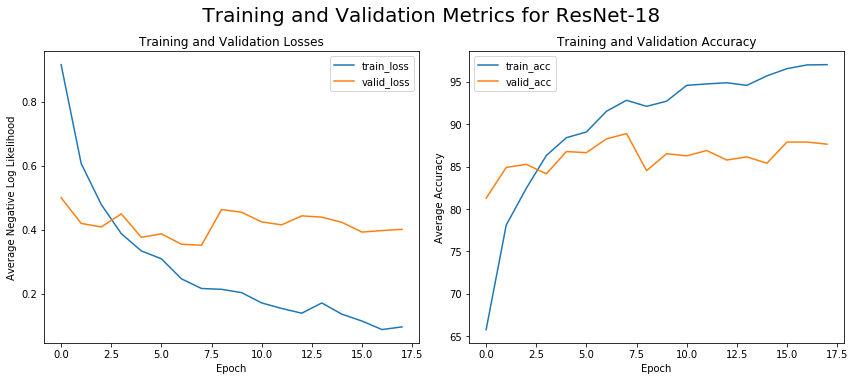

In [11]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12, 5), tight_layout = True,sharex = True)
fig.suptitle(' Training and Validation Metrics for ResNet-18', fontsize = 20, y = 1.05)
for c in ['train_loss', 'valid_loss']:
    ax1.plot(history[c], label=c)

ax1.legend()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Average Negative Log Likelihood')
ax1.set_title('Training and Validation Losses')

for c in ['train_acc', 'valid_acc']:
    ax2.plot(100 * history[c], label=c)
ax2.legend()
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Average Accuracy')
ax2.set_title('Training and Validation Accuracy')
plt.show()

In [12]:
# ConvNet as fixed feature extractor

model_conv_Res18 = models.resnet18(pretrained=True)
for param in model_conv_Res18.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv_Res18.fc.in_features
model_conv_Res18.fc = nn.Linear(num_ftrs, len(food_list))
model_conv_Res18 = model_conv_Res18.to(device) # Send the model to GPU
criterion_conv_Res18 = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv_Res18 = optim.SGD(model_conv_Res18.fc.parameters(), lr=0.0006, momentum=0.9)

# Decay LR by a factor of 0.01 every 5 epochs
exp_lr_scheduler_conv_Res18 = lr_scheduler.StepLR(optimizer_conv_Res18, step_size=5, gamma=0.01)

In [13]:
model, history = train(model_conv_Res18,criterion_conv_Res18,optimizer_conv_Res18,dataloaders['train_samples'],
                            dataloaders['validation_samples'],save_file_name= models_dir + 'resnet18_sample_1.pt',
                                max_epochs_stop=10,n_epochs=50)

Starting Training from Scratch.

Epoch: 0	100.00% complete -->  11.80 seconds elapsed in epoch.

		Training Loss: 1.1581 		Validation Loss: 0.8379
		Training Accuracy: 53.41%	Validation Accuracy: 69.54%

Epoch: 1	100.00% complete -->  13.23 seconds elapsed in epoch.

		Training Loss: 0.8850 		Validation Loss: 0.7086
		Training Accuracy: 68.06%	Validation Accuracy: 73.66%

Epoch: 2	100.00% complete -->  12.52 seconds elapsed in epoch.

		Training Loss: 0.8116 		Validation Loss: 0.6836
		Training Accuracy: 69.89%	Validation Accuracy: 74.16%

Epoch: 3	100.00% complete -->  11.79 seconds elapsed in epoch.

		Training Loss: 0.7761 		Validation Loss: 0.6607
		Training Accuracy: 70.67%	Validation Accuracy: 76.28%

Epoch: 4	100.00% complete -->  10.68 seconds elapsed in epoch.

		Training Loss: 0.7659 		Validation Loss: 0.6489
		Training Accuracy: 72.30%	Validation Accuracy: 75.78%

Epoch: 5	100.00% complete -->  10.34 seconds elapsed in epoch.

		Training Loss: 0.7339 		Validation Loss: 0.645

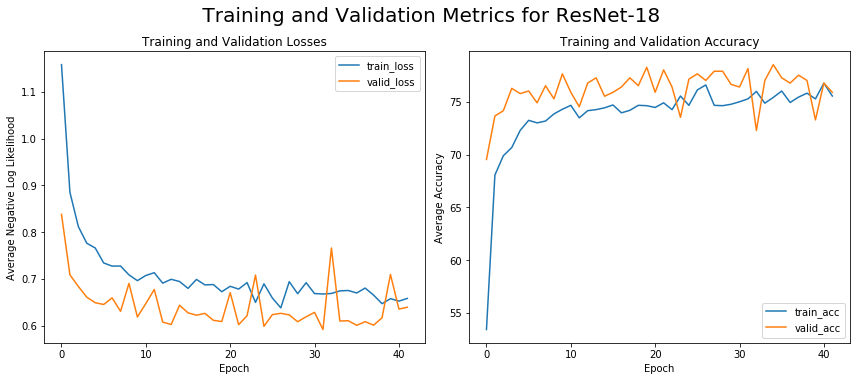

In [14]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12, 5), tight_layout = True,sharex = True)
fig.suptitle(' Training and Validation Metrics for ResNet-18', fontsize = 20, y = 1.05)
for c in ['train_loss', 'valid_loss']:
    ax1.plot(history[c], label=c)

ax1.legend()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Average Negative Log Likelihood')
ax1.set_title('Training and Validation Losses')

for c in ['train_acc', 'valid_acc']:
    ax2.plot(100 * history[c], label=c)
ax2.legend()
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Average Accuracy')
ax2.set_title('Training and Validation Accuracy')
plt.show()

**ResNet-34 Model**

In [15]:
#Fine Tune the Conv-Net

model_ft_Res34 = models.resnet34(pretrained=True)
num_ftrs = model_ft_Res34.fc.in_features
model_ft_Res34.fc = nn.Linear(num_ftrs, len(food_list))
model_ft_Res34 = model_ft_Res34.to(device)
criterion_ft_Res34 = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft_Res34 = optim.SGD(model_ft_Res34.parameters(), lr=0.0006, momentum=0.9)

# Decay LR by a factor of 0.01 every 5 epochs
exp_lr_scheduler_ft_Res34 = lr_scheduler.StepLR(optimizer_ft_Res34, step_size=5, gamma=0.01)

In [16]:
model, history = train(model_ft_Res34,criterion_ft_Res34,optimizer_ft_Res34,dataloaders['train_samples'],
                            dataloaders['validation_samples'],save_file_name= models_dir + 'resnet34_sample.pt',
                               max_epochs_stop=10,n_epochs=50)

Starting Training from Scratch.

Epoch: 0	100.00% complete -->  47.46 seconds elapsed in epoch.

		Training Loss: 0.8550 		Validation Loss: 0.4537
		Training Accuracy: 67.79%	Validation Accuracy: 83.27%

Epoch: 1	100.00% complete -->  47.68 seconds elapsed in epoch.

		Training Loss: 0.5203 		Validation Loss: 0.4363
		Training Accuracy: 81.76%	Validation Accuracy: 84.27%

Epoch: 2	100.00% complete -->  47.75 seconds elapsed in epoch.

		Training Loss: 0.4210 		Validation Loss: 0.4854
		Training Accuracy: 85.28%	Validation Accuracy: 82.90%

Epoch: 3	100.00% complete -->  49.43 seconds elapsed in epoch.

		Training Loss: 0.3040 		Validation Loss: 0.4136
		Training Accuracy: 88.98%	Validation Accuracy: 85.52%

Epoch: 4	100.00% complete -->  47.66 seconds elapsed in epoch.

		Training Loss: 0.3023 		Validation Loss: 0.4665
		Training Accuracy: 89.76%	Validation Accuracy: 85.02%

Epoch: 5	100.00% complete -->  46.90 seconds elapsed in epoch.

		Training Loss: 0.2463 		Validation Loss: 0.411

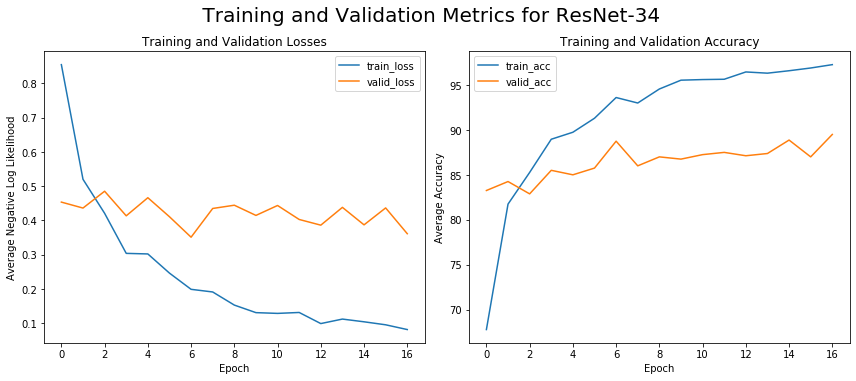

In [17]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12, 5), tight_layout = True,sharex = True)
fig.suptitle(' Training and Validation Metrics for ResNet-34', fontsize = 20, y = 1.05)
for c in ['train_loss', 'valid_loss']:
    ax1.plot(history[c], label=c)

ax1.legend()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Average Negative Log Likelihood')
ax1.set_title('Training and Validation Losses')

for c in ['train_acc', 'valid_acc']:
    ax2.plot(100 * history[c], label=c)
ax2.legend()
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Average Accuracy')
ax2.set_title('Training and Validation Accuracy')
plt.show()

In [18]:
# ConvNet as fixed feature extractor

model_conv_Res34 = models.resnet34(pretrained=True)
for param in model_conv_Res34.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv_Res34.fc.in_features
model_conv_Res34.fc = nn.Linear(num_ftrs, len(food_list))
model_conv_Res34 = model_conv_Res34.to(device) # Send the model to GPU
criterion_conv_Res34 = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv_Res34 = optim.SGD(model_conv_Res34.fc.parameters(), lr=0.0006, momentum=0.9)

# Decay LR by a factor of 0.01 every 5 epochs
exp_lr_scheduler_conv_Res34 = lr_scheduler.StepLR(optimizer_conv_Res34, step_size=5, gamma=0.01)

In [19]:
model, history = train(model_conv_Res34,criterion_conv_Res34,optimizer_conv_Res34,dataloaders['train_samples'],
                            dataloaders['validation_samples'],save_file_name= models_dir + 'resnet34_sample_1.pt',
                                max_epochs_stop=10,n_epochs=50)

Starting Training from Scratch.

Epoch: 0	100.00% complete -->  16.51 seconds elapsed in epoch.

		Training Loss: 1.1164 		Validation Loss: 0.8187
		Training Accuracy: 55.71%	Validation Accuracy: 69.04%

Epoch: 1	100.00% complete -->  16.03 seconds elapsed in epoch.

		Training Loss: 0.8594 		Validation Loss: 0.7233
		Training Accuracy: 67.89%	Validation Accuracy: 72.78%

Epoch: 2	100.00% complete -->  17.74 seconds elapsed in epoch.

		Training Loss: 0.7945 		Validation Loss: 0.7284
		Training Accuracy: 70.26%	Validation Accuracy: 72.16%

Epoch: 3	100.00% complete -->  17.73 seconds elapsed in epoch.

		Training Loss: 0.7705 		Validation Loss: 0.7185
		Training Accuracy: 71.92%	Validation Accuracy: 74.53%

Epoch: 4	100.00% complete -->  16.28 seconds elapsed in epoch.

		Training Loss: 0.7432 		Validation Loss: 0.6375
		Training Accuracy: 72.09%	Validation Accuracy: 76.28%

Epoch: 5	100.00% complete -->  16.04 seconds elapsed in epoch.

		Training Loss: 0.7250 		Validation Loss: 0.621

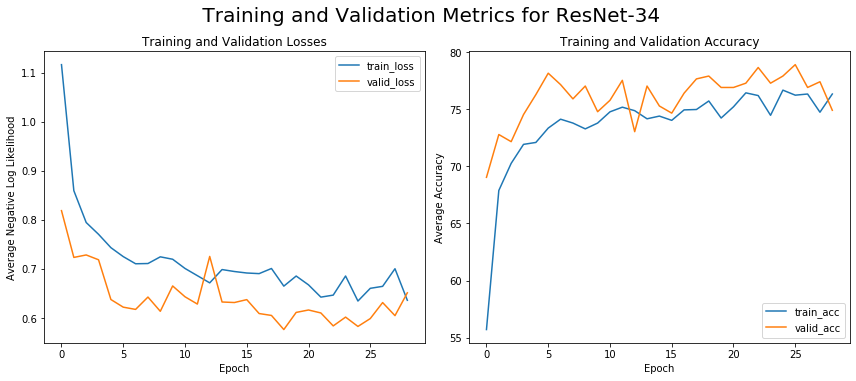

In [20]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12, 5), tight_layout = True,sharex = True)
fig.suptitle(' Training and Validation Metrics for ResNet-34', fontsize = 20, y = 1.05)
for c in ['train_loss', 'valid_loss']:
    ax1.plot(history[c], label=c)

ax1.legend()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Average Negative Log Likelihood')
ax1.set_title('Training and Validation Losses')

for c in ['train_acc', 'valid_acc']:
    ax2.plot(100 * history[c], label=c)
ax2.legend()
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Average Accuracy')
ax2.set_title('Training and Validation Accuracy')
plt.show()

**ResNet-50 Model**

In [21]:
#Fine Tune the Conv-Net

model_ft_Res50 = models.resnet50(pretrained=True)
num_ftrs = model_ft_Res50.fc.in_features
model_ft_Res50.fc = nn.Linear(num_ftrs, len(food_list))
model_ft_Res50 = model_ft_Res50.to(device)
criterion_ft_Res50 = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft_Res50 = optim.SGD(model_ft_Res50.parameters(), lr=0.0006, momentum=0.9)

# Decay LR by a factor of 0.01 every 5 epochs
exp_lr_scheduler_ft_Res50 = lr_scheduler.StepLR(optimizer_ft_Res50, step_size=5, gamma=0.01)

In [22]:
model, history = train(model_ft_Res50,criterion_ft_Res50,optimizer_ft_Res50,dataloaders['train_samples'],
                            dataloaders['validation_samples'],save_file_name= models_dir + 'resnet50_sample.pt',
                               max_epochs_stop=10,n_epochs=50)

Starting Training from Scratch.

Epoch: 0	100.00% complete -->  78.63 seconds elapsed in epoch.

		Training Loss: 0.8741 		Validation Loss: 0.4462
		Training Accuracy: 66.16%	Validation Accuracy: 85.27%

Epoch: 1	100.00% complete -->  78.12 seconds elapsed in epoch.

		Training Loss: 0.5170 		Validation Loss: 0.4166
		Training Accuracy: 81.96%	Validation Accuracy: 85.64%

Epoch: 2	100.00% complete -->  79.31 seconds elapsed in epoch.

		Training Loss: 0.4032 		Validation Loss: 0.3438
		Training Accuracy: 85.83%	Validation Accuracy: 88.14%

Epoch: 3	100.00% complete -->  78.86 seconds elapsed in epoch.

		Training Loss: 0.2943 		Validation Loss: 0.3998
		Training Accuracy: 89.66%	Validation Accuracy: 86.27%

Epoch: 4	100.00% complete -->  78.17 seconds elapsed in epoch.

		Training Loss: 0.2712 		Validation Loss: 0.4367
		Training Accuracy: 90.23%	Validation Accuracy: 85.64%

Epoch: 5	100.00% complete -->  78.46 seconds elapsed in epoch.

		Training Loss: 0.2313 		Validation Loss: 0.360

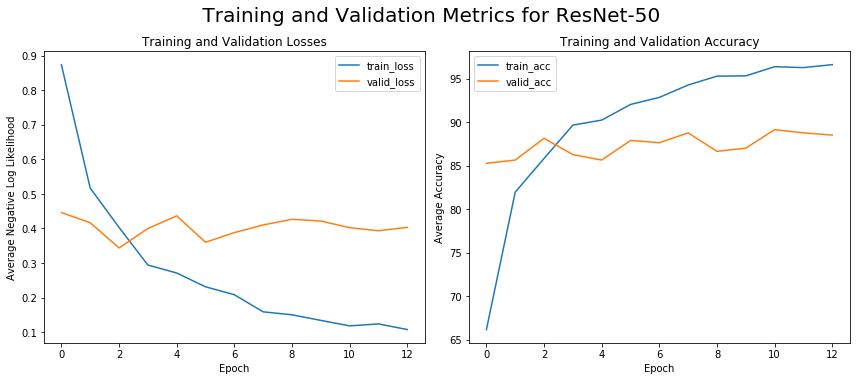

In [23]:
fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12, 5), tight_layout = True,sharex = True)
fig.suptitle(' Training and Validation Metrics for ResNet-50', fontsize = 20, y = 1.05)
for c in ['train_loss', 'valid_loss']:
    ax1.plot(history[c], label=c)

ax1.legend()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Average Negative Log Likelihood')
ax1.set_title('Training and Validation Losses')

for c in ['train_acc', 'valid_acc']:
    ax2.plot(100 * history[c], label=c)
ax2.legend()
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Average Accuracy')
ax2.set_title('Training and Validation Accuracy')
plt.show()

In [24]:
# ConvNet as fixed feature extractor

model_conv_Res50 = models.resnet50(pretrained=True)
for param in model_conv_Res50.parameters():
    param.requires_grad = False

# Parameters of newly constructed modules have requires_grad=True by default
num_ftrs = model_conv_Res50.fc.in_features
model_conv_Res50.fc = nn.Linear(num_ftrs, len(food_list))
model_conv_Res50 = model_conv_Res50.to(device) # Send the model to GPU
criterion_conv_Res50 = nn.CrossEntropyLoss()

# Observe that only parameters of final layer are being optimized as
# opposed to before.
optimizer_conv_Res50 = optim.SGD(model_conv_Res50.fc.parameters(), lr=0.0006, momentum=0.9)

# Decay LR by a factor of 0.01 every 5 epochs
exp_lr_scheduler_conv_Res50 = lr_scheduler.StepLR(optimizer_conv_Res50, step_size=5, gamma=0.01)

In [25]:
model, history = train(model_conv_Res50,criterion_conv_Res50,optimizer_conv_Res50,dataloaders['train_samples'],
                            dataloaders['validation_samples'],save_file_name= models_dir + 'resnet50_sample_1.pt',
                                max_epochs_stop=10,n_epochs=50)

Starting Training from Scratch.

Epoch: 0	100.00% complete -->  24.84 seconds elapsed in epoch.

		Training Loss: 1.1743 		Validation Loss: 0.8212
		Training Accuracy: 54.66%	Validation Accuracy: 73.41%

Epoch: 1	100.00% complete -->  24.98 seconds elapsed in epoch.

		Training Loss: 0.8755 		Validation Loss: 0.7900
		Training Accuracy: 67.92%	Validation Accuracy: 69.29%

Epoch: 2	100.00% complete -->  24.91 seconds elapsed in epoch.

		Training Loss: 0.7946 		Validation Loss: 0.6931
		Training Accuracy: 71.52%	Validation Accuracy: 74.03%

Epoch: 3	100.00% complete -->  24.88 seconds elapsed in epoch.

		Training Loss: 0.7510 		Validation Loss: 0.6272
		Training Accuracy: 73.18%	Validation Accuracy: 77.53%

Epoch: 4	100.00% complete -->  24.74 seconds elapsed in epoch.

		Training Loss: 0.7292 		Validation Loss: 0.6321
		Training Accuracy: 73.72%	Validation Accuracy: 75.91%

Epoch: 5	100.00% complete -->  25.32 seconds elapsed in epoch.

		Training Loss: 0.7087 		Validation Loss: 0.607

Epoch: 48	100.00% complete -->  27.76 seconds elapsed in epoch.

		Training Loss: 0.5940 		Validation Loss: 0.5136
		Training Accuracy: 79.38%	Validation Accuracy: 81.77%

Epoch: 49	100.00% complete -->  27.60 seconds elapsed in epoch.

		Training Loss: 0.5672 		Validation Loss: 0.4953
		Training Accuracy: 79.38%	Validation Accuracy: 81.90%


Best epoch: 43 with loss: 0.49 and acc: 80.40%
1662.90 total seconds elapsed. 33.94 seconds per epoch.


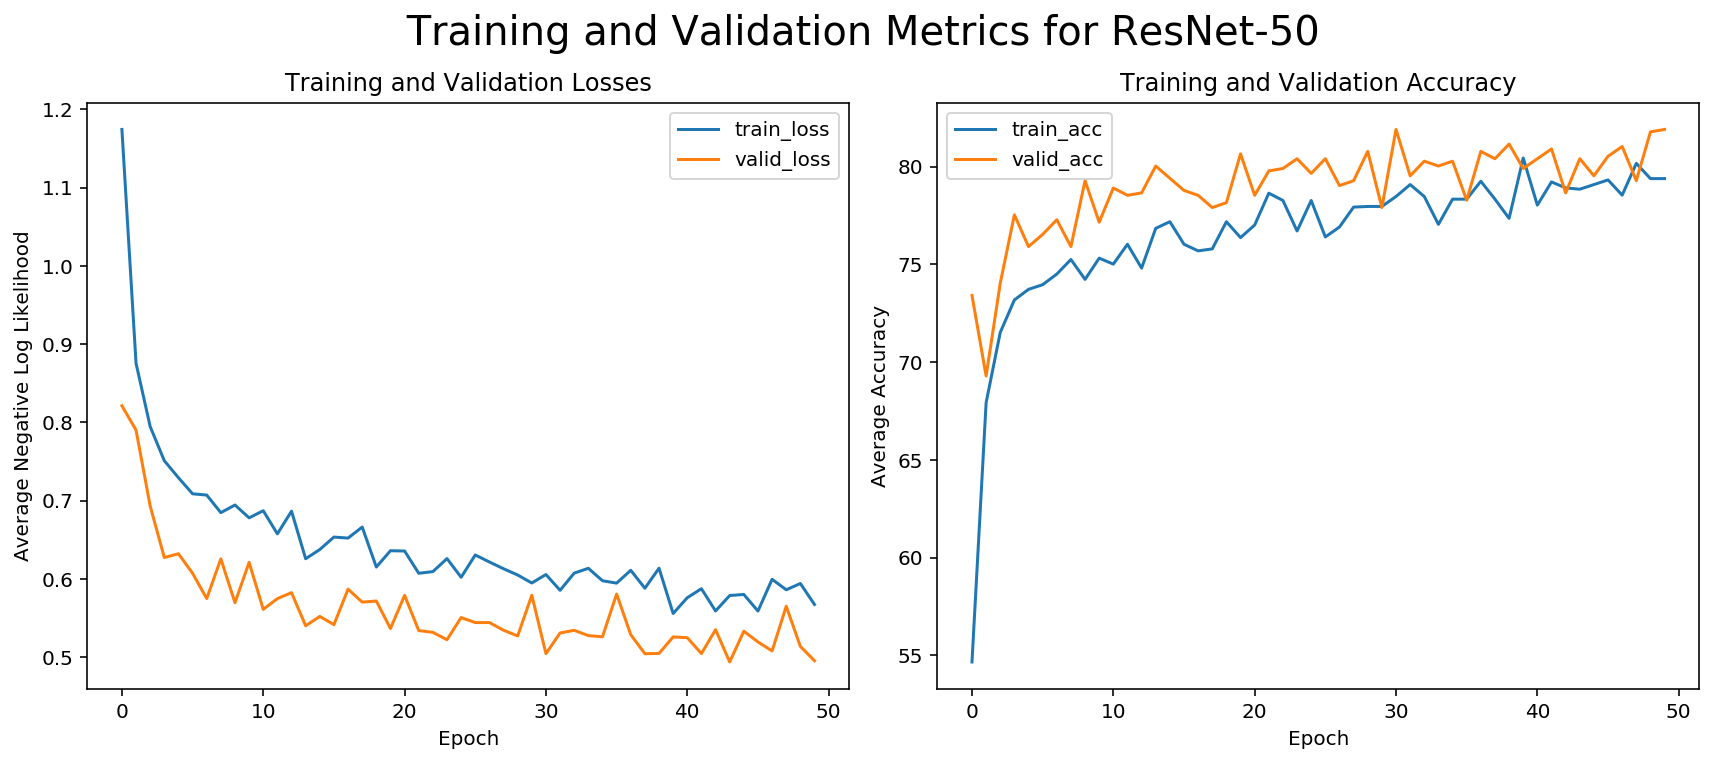

In [26]:
%config InlineBackend.figure_format = 'retina'

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12, 5), tight_layout = True,sharex = True)
fig.suptitle(' Training and Validation Metrics for ResNet-50', fontsize = 20, y = 1.05)
for c in ['train_loss', 'valid_loss']:
    ax1.plot(history[c], label=c)

ax1.legend()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Average Negative Log Likelihood')
ax1.set_title('Training and Validation Losses')

for c in ['train_acc', 'valid_acc']:
    ax2.plot(100 * history[c], label=c)
ax2.legend()
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Average Accuracy')
ax2.set_title('Training and Validation Accuracy')
plt.show()

In [ ]:
summary(model_ft_Res18, input_size=(3, 224, 224), batch_size=8)

# **Final Model**

In [17]:
# Fine tune the model

model_ft_Res50 = models.resnet50(pretrained=True)
num_ftrs = model_ft_Res50.fc.in_features
model_ft_Res50.fc = nn.Linear(num_ftrs, 101)
model_ft_Res50 = model_ft_Res50.to(device)
criterion_ft_Res50 = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft_Res50 = optim.SGD(model_ft_Res50.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.01 every 5 epochs
exp_lr_scheduler_ft_Res50 = lr_scheduler.StepLR(optimizer_ft_Res50, step_size=7, gamma=0.1)

In [18]:
model, history = train(model_ft_Res50,criterion_ft_Res50,optimizer_ft_Res50,dataloaders['train'],
                            dataloaders['validation'],save_file_name= models_dir + 'resnet50_ft.pt',
                               max_epochs_stop=5,n_epochs=30)

Starting Training from Scratch.

Epoch: 0	100.00% complete -->  2200.84 seconds elapsed in epoch.

		Training Loss: 2.6866 		Validation Loss: 2.0092
		Training Accuracy: 35.07%	Validation Accuracy: 54.49%

Epoch: 1	100.00% complete -->  2085.75 seconds elapsed in epoch.

		Training Loss: 1.9375 		Validation Loss: 1.6601
		Training Accuracy: 51.36%	Validation Accuracy: 62.03%

Epoch: 2	100.00% complete -->  1948.58 seconds elapsed in epoch.

		Training Loss: 1.6472 		Validation Loss: 1.5417
		Training Accuracy: 57.99%	Validation Accuracy: 65.13%

Epoch: 3	100.00% complete -->  1950.94 seconds elapsed in epoch.

		Training Loss: 1.4588 		Validation Loss: 1.3733
		Training Accuracy: 62.28%	Validation Accuracy: 67.40%

Epoch: 4	100.00% complete -->  1951.26 seconds elapsed in epoch.

		Training Loss: 1.3222 		Validation Loss: 1.3440
		Training Accuracy: 65.39%	Validation Accuracy: 68.95%

Epoch: 5	100.00% complete -->  1951.63 seconds elapsed in epoch.

		Training Loss: 1.2120 		Validation

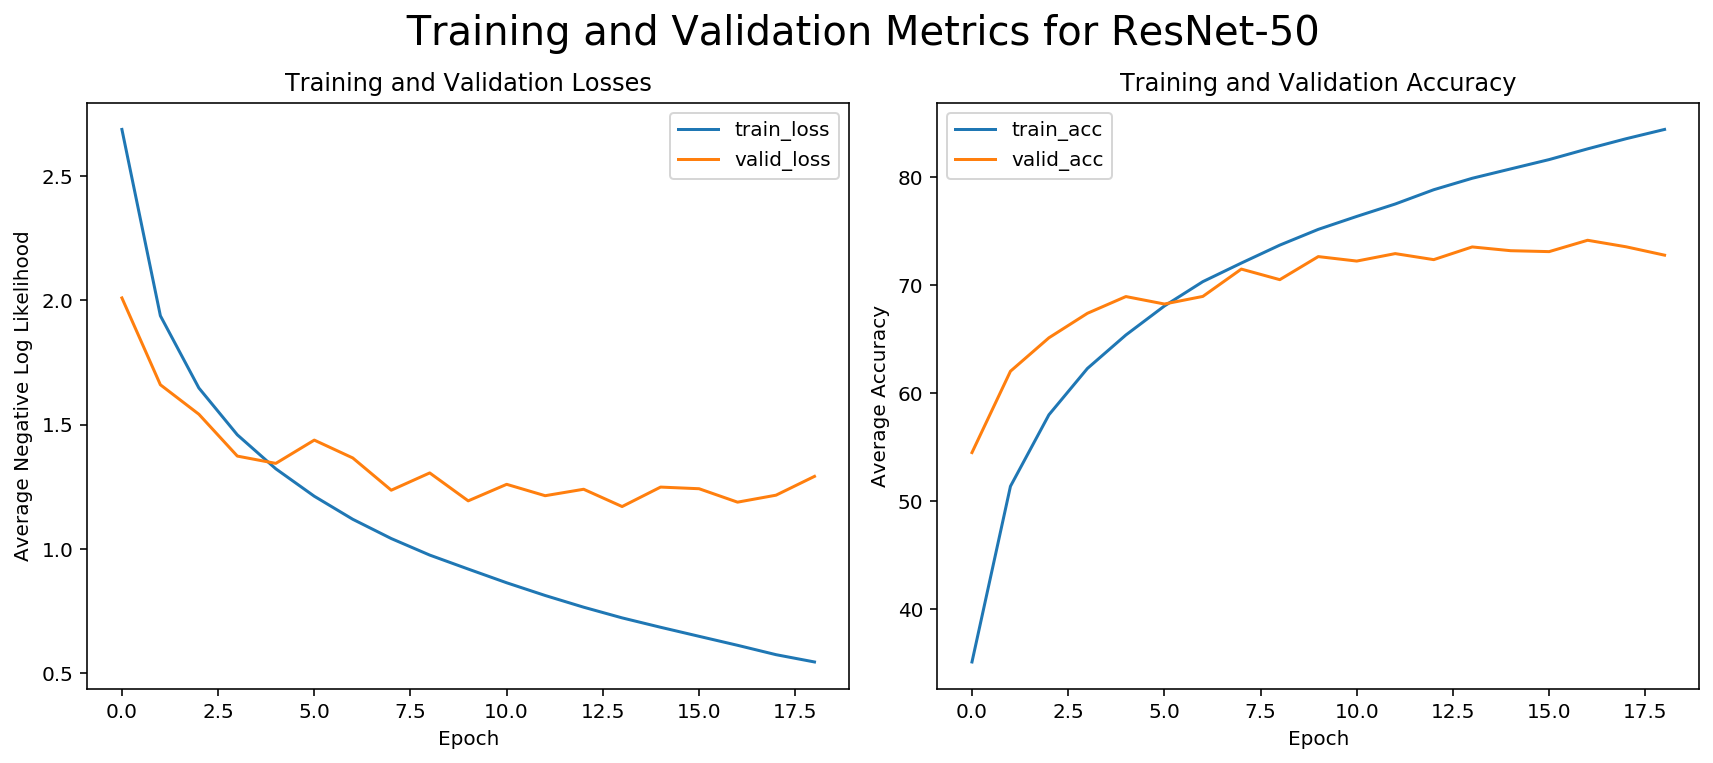

In [19]:
%config InlineBackend.figure_format = 'retina'

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12, 5), tight_layout = True,sharex = True)
fig.suptitle(' Training and Validation Metrics for ResNet-50', fontsize = 20, y = 1.05)
for c in ['train_loss', 'valid_loss']:
    ax1.plot(history[c], label=c)

ax1.legend()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Average Negative Log Likelihood')
ax1.set_title('Training and Validation Losses')

for c in ['train_acc', 'valid_acc']:
    ax2.plot(100 * history[c], label=c)
ax2.legend()
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Average Accuracy')
ax2.set_title('Training and Validation Accuracy')
plt.show()

In [ ]:
model, history = train(model_ft_Res50,criterion_ft_Res50,optimizer_ft_Res50,dataloaders['train'],
                            dataloaders['validation'],save_file_name= models_dir + 'resnet50_ft.pt',
                               max_epochs_stop=5,n_epochs=30)

In [21]:
# Fine tune the ResNet-18 model 

model_ft_Res18 = models.resnet18(pretrained=True)
num_ftrs = model_ft_Res18.fc.in_features
model_ft_Res18.fc = nn.Linear(num_ftrs, 101)
model_ft_Res18 = model_ft_Res18.to(device)
criterion_ft_Res18 = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft_Res18 = optim.SGD(model_ft_Res18.parameters(), lr=0.0006, momentum=0.9)

# Decay LR by a factor of 0.01 every 5 epochs
exp_lr_scheduler_ft_Res18 = lr_scheduler.StepLR(optimizer_ft_Res18, step_size=5, gamma=0.01)


In [22]:
f_model, f_history = train(model_ft_Res18,criterion_ft_Res18,optimizer_ft_Res18,dataloaders['train'],
                            dataloaders['test'],save_file_name= models_dir + 'resnet18.pt',
                               max_epochs_stop=15,n_epochs=50)

Starting Training from Scratch.

Epoch: 0	100.00% complete -->  727.51 seconds elapsed in epoch.

		Training Loss: 2.7443 		Validation Loss: 1.5808
		Training Accuracy: 34.08%	Validation Accuracy: 60.51%

Epoch: 1	100.00% complete -->  731.12 seconds elapsed in epoch.

		Training Loss: 2.1032 		Validation Loss: 1.5113
		Training Accuracy: 47.67%	Validation Accuracy: 63.12%

Epoch: 2	100.00% complete -->  731.05 seconds elapsed in epoch.

		Training Loss: 1.8825 		Validation Loss: 1.3666
		Training Accuracy: 53.06%	Validation Accuracy: 67.06%

Epoch: 3	100.00% complete -->  734.41 seconds elapsed in epoch.

		Training Loss: 1.7165 		Validation Loss: 1.4352
		Training Accuracy: 56.84%	Validation Accuracy: 66.86%

Epoch: 4	100.00% complete -->  732.83 seconds elapsed in epoch.

		Training Loss: 1.6018 		Validation Loss: 1.2697
		Training Accuracy: 59.25%	Validation Accuracy: 69.92%

Epoch: 5	100.00% complete -->  730.60 seconds elapsed in epoch.

		Training Loss: 1.4969 		Validation Loss:

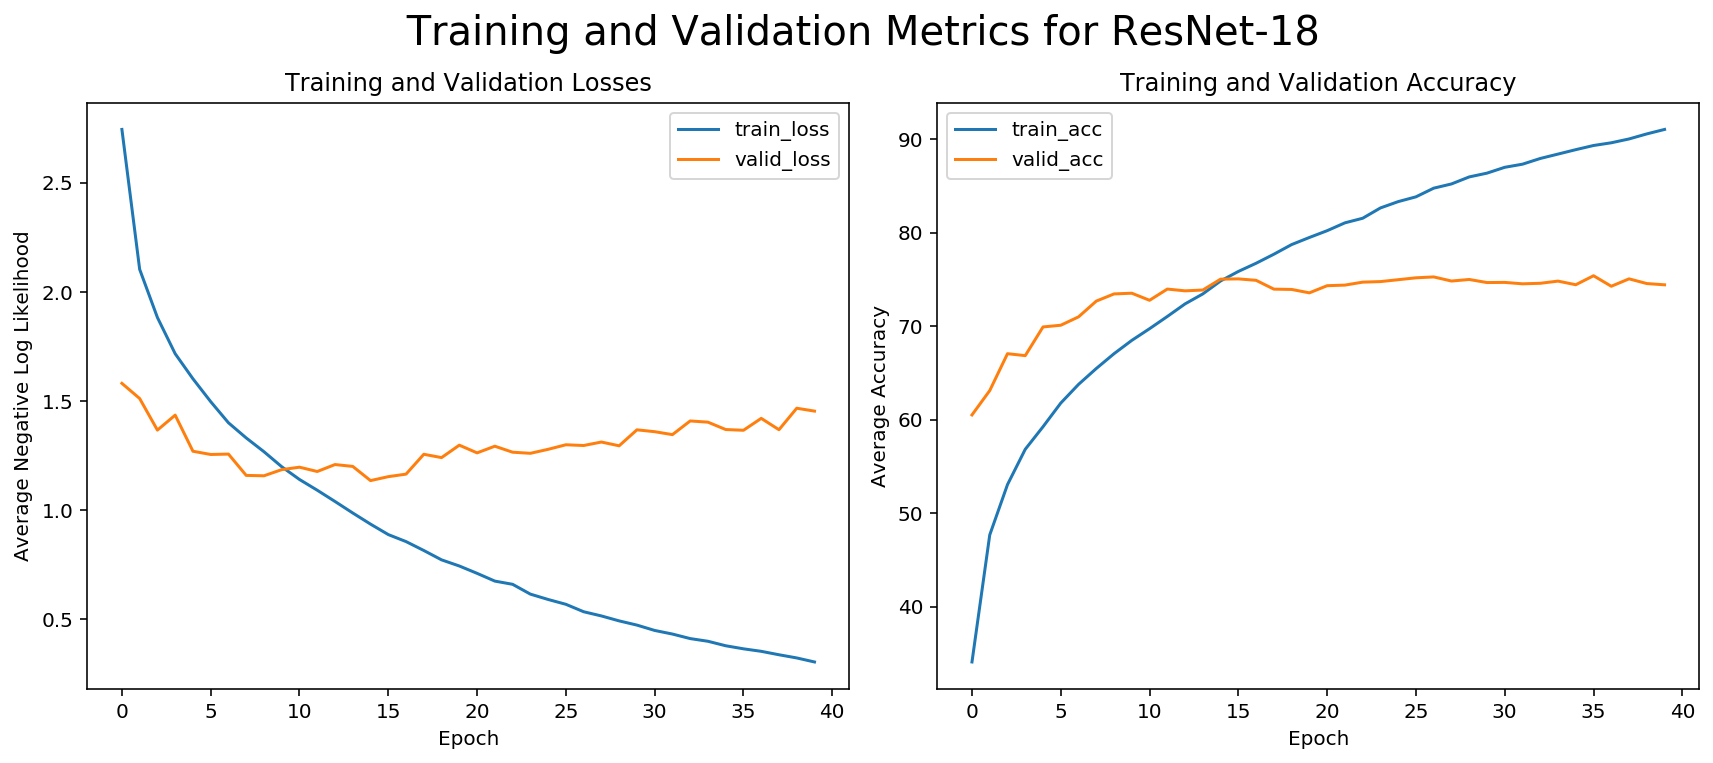

In [31]:
%config InlineBackend.figure_format = 'retina'

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(12, 5), tight_layout = True,sharex = True)
fig.suptitle(' Training and Validation Metrics for ResNet-18', fontsize = 20, y = 1.05)
for c in ['train_loss', 'valid_loss']:
    ax1.plot(f_history[c], label=c)

ax1.legend()
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Average Negative Log Likelihood')
ax1.set_title('Training and Validation Losses')

for c in ['train_acc', 'valid_acc']:
    ax2.plot(100 * f_history[c], label=c)
ax2.legend()
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Average Accuracy')
ax2.set_title('Training and Validation Accuracy')
plt.show()

**Results:**

    1. ResNet-18 (sample dataset) - *Loss:* 0.35  *Accuracy:* 88.89%
    2. ResNet-34 (sample dataset) - *Loss:* 0.35  *Accuracy:* 88.76%
    3. ResNet-50 (sample dataset) - *Loss:* 0.34  *Accuracy:* 88.14%
    4. ResNet-18 (Main)           - *Loss:* 1.14  *Accuracy:* 75.04%
    5. ResNet-50 (Main)           - *Loss:* 1.17  *Accuracy:* 73.55%
    

**Conclusion:**
    
    I have understood how to use PyTorch for deep learning and computer vision applications. I thought it would  be relevant to perform the challenge using PyTorch library instead of fast.ai so that I would get a good grip of what is going on in each layer of the model. 
    
    Due to shortage of time and resources, the model couldn't be trained and tested any further. The model submitted for the fellowship.ai challenge demands 6-8 whole days of run time to structure the network and test the model to reach to a optimized state. 

**Future Scope:** 
    
    1. Models like Squeezenet, Inception or deeper ResNet could improve the result and achieve better performance where computation time and cost plays a major role.
    
    2. Libraries such as Theano, Lasagne, Fast.ai are light weight libraries which can be implemented to build and train neural network in a optimized way.
    
    3. Better transformation techniques such as padding, brightness, grayscale, sizing and cropping techniques can be used to train the model. 
    